In [1]:
%matplotlib inline

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

from typing import Callable, Dict, Tuple, List, Optional

In [2]:
from sklearn.datasets import load_boston

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils

In [3]:
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [4]:
s = StandardScaler()
data = s.fit_transform(data)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)


## Keras

In [6]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [7]:
# create model
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

In [8]:
# checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early_stop = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=2,
#                               verbose=0, mode='auto')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train,y_train, batch_size=23, epochs=100, verbose=1)

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 346.3387 - mse: 346.3387
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 47.9897 - mse: 47.9897
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 34.7853 - mse: 34.7853
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 30.4354 - mse: 30.4354
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 26.1046 - mse: 26.1046
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 23.4968 - mse: 23.4968
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 20.6812 - mse: 20.6812
Epoch 8/100
16/16 [==============================] - 0s 1ms/step - loss: 18.3333 - mse: 18.3333
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 15.9752 - mse: 15.9752
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 19.0503 - mse: 19.0503
Epoch 11/100
16/16 [=================

16/16 [==============================] - 0s 1ms/step - loss: 5.3954 - mse: 5.3954
Epoch 87/100
16/16 [==============================] - 0s 1ms/step - loss: 5.9502 - mse: 5.9502
Epoch 88/100
16/16 [==============================] - 0s 1ms/step - loss: 5.6581 - mse: 5.6581
Epoch 89/100
16/16 [==============================] - 0s 2ms/step - loss: 5.5753 - mse: 5.5753
Epoch 90/100
16/16 [==============================] - 0s 2ms/step - loss: 5.4797 - mse: 5.4797
Epoch 91/100
16/16 [==============================] - 0s 1ms/step - loss: 6.1258 - mse: 6.1258
Epoch 92/100
16/16 [==============================] - 0s 1ms/step - loss: 5.7393 - mse: 5.7393
Epoch 93/100
16/16 [==============================] - 0s 1ms/step - loss: 5.4816 - mse: 5.4816
Epoch 94/100
16/16 [==============================] - 0s 2ms/step - loss: 5.6975 - mse: 5.6975
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 5.3912 - mse: 5.3912
Epoch 96/100
16/16 [==============================] - 0s 1ms/st

In [11]:
test_pred = model.predict(X_test)
test_actual = y_test

In [12]:
mean_squared_error(test_pred, test_actual)

13.150872037106064

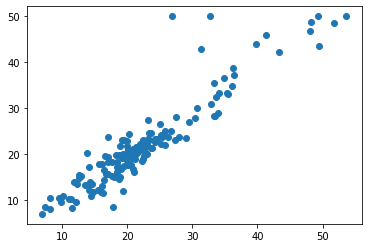

In [13]:
plt.scatter(test_pred, test_actual)

## PyTorch

In [14]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim import lr_scheduler
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader

In [15]:
class PyTorchTrainer(object):
    def __init__(self,
                 model,
                 optim: Optimizer,
                 criterion: _Loss):
        self.model = model
        self.optim = optim
        self.loss = criterion
        self._check_optim_net_aligned()

    def _check_optim_net_aligned(self):
        assert self.optim.param_groups[0]['params']\
            == list(self.model.parameters())

    def _generate_batches(self,
                          X: Tensor,
                          y: Tensor,
                          size: int = 32) -> Tuple[Tensor]:

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

    def _permute_data(self, X: Tensor, y: Tensor, seed=1) -> Tuple[Tensor]:
        perm = torch.randperm(X.shape[0])
        return X[perm], y[perm]

    def fit(self, X_train: Tensor = None,
            y_train: Tensor = None,
            X_test: Tensor = None,
            y_test: Tensor = None,
            train_dataloader: DataLoader = None,
            test_dataloader: DataLoader = None,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            final_lr_exp: int = None):

        init_lr = self.optim.param_groups[0]['lr']
        if final_lr_exp:
            decay = (final_lr_exp / init_lr) ** (1.0 / (epochs + 1))
            scheduler = lr_scheduler.ExponentialLR(self.optim, gamma=decay)
        for e in range(epochs):

            if final_lr_exp:
                scheduler.step()

            if not train_dataloader:
                X_train, y_train = self._permute_data(X_train, y_train)

                batch_generator = self._generate_batches(X_train, y_train,
                                                         batch_size)

                self.model.train()

                for ii, (X_batch, y_batch) in enumerate(batch_generator):

                    self.optim.zero_grad()   # zero the gradient buffers

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        output = self.model(X_test)[0]
                        loss = self.loss(output, y_test)
                        print("The loss after", e+1, "epochs was", loss.item())

            else:
                for X_batch, y_batch in train_dataloader:

                    self.optim.zero_grad()

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        losses = []
                        for X_batch, y_batch in test_dataloader:
                            output = self.model(X_batch)[0]
                            loss = self.loss(output, y_batch)
                            losses.append(loss.item())
                        print("The loss after", e, "epochs was",
                              round(torch.Tensor(losses).mean().item(), 4))

In [16]:
class PyTorchLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        raise NotImplementedError()
        
        
class PyTorchModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tuple[Tensor]:
        raise NotImplementedError()
        
        
def assert_dim(t: Tensor,
               dim: Tensor):
    assert len(t.shape) == dim, \
        '''
        Tensor expected to have dimension {0}, instead has dimension {1}
        '''.format(dim, len(t.shape))
    return None

In [17]:
def inference_mode(m: nn.Module):
    m.eval()
        
        
class DenseLayer(PyTorchLayer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 dropout: float = 1.0,
                 activation: nn.Module = None) -> None:

        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        if inference:
            self.apply(inference_mode)

        x = self.linear(x)  # does weight multiplication + bias
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)

        return x

In [18]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, 
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),

In [19]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [20]:
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
optimizer = torch.optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.MSELoss()

In [21]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion)

trainer.fit(X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)

/Users/steffen/miniconda3/envs/deep_learning/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


The loss after 1 epochs was 405.6063537597656
The loss after 11 epochs was 27.64900016784668
The loss after 21 epochs was 20.719297409057617
The loss after 31 epochs was 23.351734161376953
The loss after 41 epochs was 20.33896827697754
The loss after 51 epochs was 19.70602035522461
The loss after 61 epochs was 18.885042190551758
The loss after 71 epochs was 15.947514533996582
The loss after 81 epochs was 18.582767486572266
The loss after 91 epochs was 16.953500747680664


In [22]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

16.172704696655273

In [23]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test

In [24]:
test_pred = test_pred.detach().numpy()
test_actual = test_actual.detach().numpy()

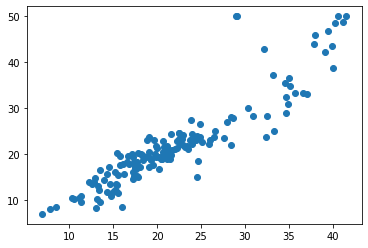

In [25]:
plt.scatter(test_pred, test_actual)

## TensorFlow